In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm

In [2]:
# считываем данные
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [3]:
# всего четыре версии приложения
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

Делим по группе.

In [4]:
# experimentVariant = 0
x = df[df.experimentVariant == 0]['purchase']
x.shape

(63102,)

In [5]:
# experimentVariant = 1
y = df[df.experimentVariant == 1]['purchase']
y.shape

(63916,)

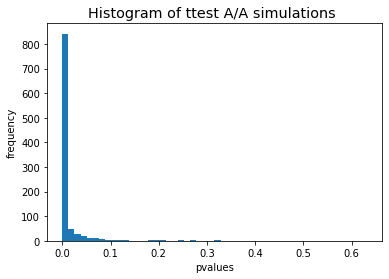

0.936

In [6]:
# проводим A/A тест
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = x.sample(n_s, replace = False).values
    s2 = y.sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR значительно больше альфа! Система сплитования сломана.

Поищем причины поломки.

In [8]:
# считаем конверсию, группируя по варианту и версии МП
df.groupby(['version', 'experimentVariant'], as_index=False).agg({'purchase': 'mean', 'uid': 'count'})

,version,experimentVariant,purchase,uid
0,v2.8.0,0,0.000993,41283
1,v2.8.0,1,0.045606,41552
2,v2.9.0,0,0.074658,11921
3,v2.9.0,1,0.071304,12033
4,v3.7.4.0,0,0.059943,4204
5,v3.7.4.0,1,0.063018,4221
6,v3.8.0.0,0,0.057604,5694
7,v3.8.0.0,1,0.062848,6110


Наблюдаем значительную разницу по среднему конверсии в версии v2.8.0.

Проверим pvalue для каждой версии МП.

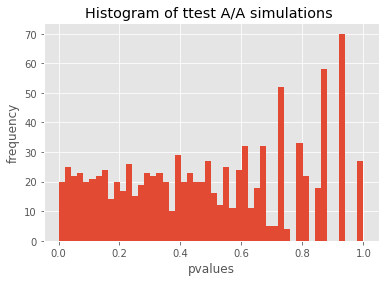

0.061

In [9]:
# version 2.9.0
x = df[(df.experimentVariant == 0) & (df.version == 'v2.9.0')]['purchase']
y = df[(df.experimentVariant == 1) & (df.version == 'v2.9.0')]['purchase']
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = x.sample(n_s, replace = False).values
    s2 = y.sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR < 0.05 или незначительно выше.

In [10]:
# проверка на нормальное распределение - выбрать ttest или U-тест
st.normaltest(x)

NormaltestResult(statistic=7663.744013159911, pvalue=0.0)

In [11]:
# pvalue не позволяет уверенно утверждать, что между группами v2.9.0 есть стат.значимые различия
st.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=71963272.5, pvalue=0.31829983470708123)

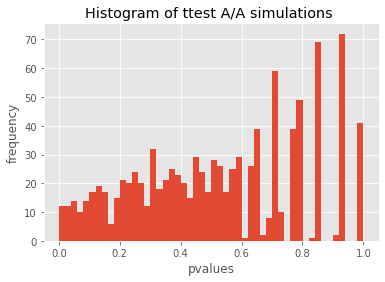

0.031

In [12]:
# version 3.7.4.0
x = df[(df.experimentVariant == 0) & (df.version == 'v3.7.4.0')]['purchase']
y = df[(df.experimentVariant == 1) & (df.version == 'v3.7.4.0')]['purchase']
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = x.sample(n_s, replace = False).values
    s2 = y.sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR < 0.05 или незначительно выше.

In [13]:
# проверка на нормальное распределение
st.normaltest(x)

NormaltestResult(statistic=3123.329625744318, pvalue=0.0)

In [14]:
# pvalue не позволяет уверенно утверждать, что между группами v3.7.4.0 есть стат.значимые различия
st.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=8845256.0, pvalue=0.5568648248217467)

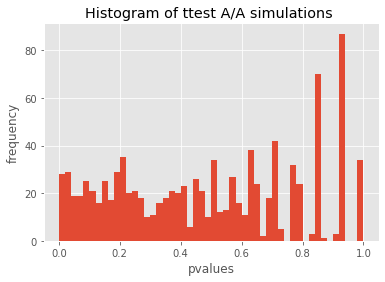

0.066

In [15]:
# version 3.8.0.0
x = df[(df.experimentVariant == 0) & (df.version == 'v3.8.0.0')]['purchase']
y = df[(df.experimentVariant == 1) & (df.version == 'v3.8.0.0')]['purchase']
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = x.sample(n_s, replace = False).values
    s2 = y.sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR < 0.05 или незначительно выше.

In [16]:
# проверка на нормальное распределение
st.normaltest(x)

NormaltestResult(statistic=4318.4529044037445, pvalue=0.0)

In [17]:
# pvalue не позволяет уверенно утверждать, что между группами v3.8.0.0 есть стат.значимые различия
st.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=17303962.0, pvalue=0.23185636638957852)

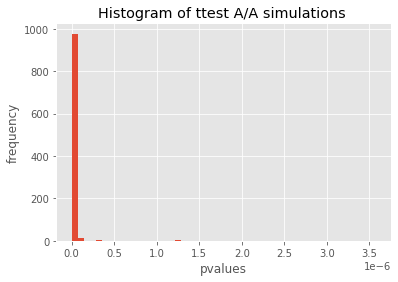

1.0

In [18]:
# version 2.8.0
x = df[(df.experimentVariant == 0) & (df.version == 'v2.8.0')]['purchase']
y = df[(df.experimentVariant == 1) & (df.version == 'v2.8.0')]['purchase']
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = x.sample(n_s, replace = False).values
    s2 = y.sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR намного выше 0.05!

In [19]:
# проверка на нормальное распределение
st.normaltest(x)

NormaltestResult(statistic=108784.82483008405, pvalue=0.0)

In [20]:
# pvalue говорит о том, что между группами v2.8.0 возможны стат.значимые различия
st.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=819431781.5, pvalue=0.0)

Исключим из основных данных версию 2.8.0 и посмотрим на FPR.

In [21]:
new_df = df[df.version != 'v2.8.0']
new_df.head()

,uid,experimentVariant,version,purchase
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
6,8f14e45fceea167a5a36dedd4bea2543,0,v2.9.0,0
10,6512bd43d9caa6e02c990b0a82652dca,1,v2.9.0,0
13,aab3238922bcc25a6f606eb525ffdc56,1,v2.9.0,0


In [22]:
new_df.shape

(44183, 4)

In [23]:
# experimentVariant = 0
x = new_df[new_df.experimentVariant == 0]['purchase']
x.shape

(21819,)

In [24]:
# experimentVariant = 1
y = new_df[new_df.experimentVariant == 1]['purchase']
y.shape

(22364,)

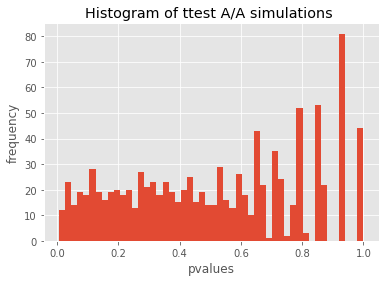

0.037

In [25]:
# проводим A/A тест

n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = x.sample(n_s, replace = False).values
    s2 = y.sample(n_s, replace = False).values
    res.append(st.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR < 0.05 или незначительно выше.

In [26]:
# дополнительно посмотрим на процент пользователей, пользующихся версией 2.8.0 - около 65%!
1 - (new_df.shape[0] / df.shape[0])

0.6521516635437496

# Выводы

1) Значительные различия наблюдались в группах, использующих версию приложения 2.8.0, - существенное различие в конверсии. За этим исключением, группы имели более-менее равные количество участников и процент конверсии.

2) Сплит-система сломана, причина поломки - версия 2.8.0 ломает систему (аномалия). Не знаю, стоит ли иметь в виду тот фактор, что пользователи этого приложения составляют ~65% от всех пользователей, хотя, кажется, версия 2.8.0 является наиболее старой. Стоит ли её исключить, оставив около 35% от исходных данных, или же сплитовать по-другому? (Я интуитивно больше за 2 вариант, так как версия 2.8.0. может быть наиболее популярной среди пользователей и не хотелось бы упускать ее из виду.) Есть ли другие версии приложения, кроме этих четырёх?